In [1]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# def toFitFran(ep1,ep2,d,s1,l1,s2,l2,anguloR,landa):
#     '''
#     funcion a fitear. 
#     devuelve un tensor
#     '''

#     s0s = generadorFran(ep1,ep2,d,s1,l1,s2,l2,incAng,landa)
    
#     pp = len(s0s[1])
    
#     a = TT.zeros(pp)
# #     print(s0s[1][0])
#     for i in range(pp):
#         a = TT.set_subtensor(a[i], s0s[1][i])
    
    
#     return a

def s0_hensley(beta0, beta1, beta2, M):
    out = beta0*(1-np.exp(-beta1*M))+beta2*(M**0.2)*np.exp(-beta1*M)
    return 10*np.log10(out)

In [3]:
# test s0_hensley
# beta1 = 0.018
# beta0 = 0.066
# beta2 = 0.023

# M = np.arange(10,300)
# s0HV = s0_hensley(beta0, beta1, beta2, M)
# plt.plot(M, s0HV)

In [4]:
def modeloInferencia(datos, sigma, samples):
    '''
    wrap del modelo bayesiano
    '''

    print('Fiteando '+str(datos))
    
    ranges = {}
    ranges['beta0'] = 0.001, 0.1
    ranges['beta1'] = 0.001, 0.1
    ranges['beta2'] = 0.001, 0.1
    
    with pm.Model() as model:
        beta0 = pm.Uniform('beta0', ranges['beta0'][0], ranges['beta0'][1])
        beta1 = pm.Uniform('beta1', ranges['beta1'][0], ranges['beta1'][1])
        beta2 = pm.Uniform('beta2', ranges['beta2'][0], ranges['beta2'][1])

    def f(beta0 = beta0,
            beta1 = beta1,
            beta2 = beta2):

        return s0_hensley(beta0, beta1, beta2, M)
    
    with model:
        function_pm = pm.Deterministic('s0f', f())
        datos_shared = pm.Data("pred", datos)
        observations = pm.Normal( "obs",  mu=function_pm, sigma=sigma, observed=datos_shared)
        # trace = pm.sample_smc(samples, cores=4, parallel=True)  
        # trace = pm.sample_smc(samples, cores=4)  
        trace = pm.sample(samples, tune=2000, cores=4)  
        ppc = pm.sample_prior_predictive(samples=50)
    
    return trace, ppc, model

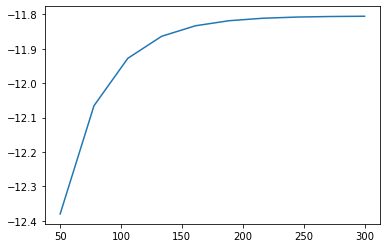

In [5]:
# mediciones de verdad

# M = np.asarray([50, 100, 150, 200]) #en Tn/Ha
# radarObs = np.asarray([-13, -12.5, -12, -11.5]) #en dB

# mediciones sinteticas

M = np.linspace(50, 300, 10) #en Tn/Ha

beta1 = 0.02
beta0 = 0.066
# beta2 = 0.023
beta2 = 0.02

radarObs = s0_hensley(beta0, beta1, beta2, M)

plt.plot(M, radarObs)



In [6]:
muestras = 5000
Nombre = 'Chicote'

sig = 0.01 #dB

# sig = np.asarray(len(incAng)*[0.1])  #pruebas error

traza, ppc, model = modeloInferencia(radarObs,
                        sig,
                        muestras)

#------------ error para generadorEmisividad()) ------------#
# sig = np.asarray(len(angR)*[noiseSTD**2] + len(ang)*[0.001])
# traza = modelo([angR,seR],ang,muestras,sig)

Fiteando [-12.38004738 -12.06536362 -11.92754044 -11.86342199 -11.83281176
 -11.81804934 -11.81092182 -11.80749924 -11.80587471 -11.80511807]


/tmp/ipykernel_73134/1188732119.py:30: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples, tune=2000, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]


Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 25 seconds.
There were 64 divergences after tuning. Increase `target_accept` or reparameterize.
There were 512 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5042307394249461, but should be close to 0.8. Try to increase the number of tuning steps.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
import arviz as az

In [8]:
az_trace = az.from_pymc3(traza)

/home/tele/miniconda3/envs/bayes/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


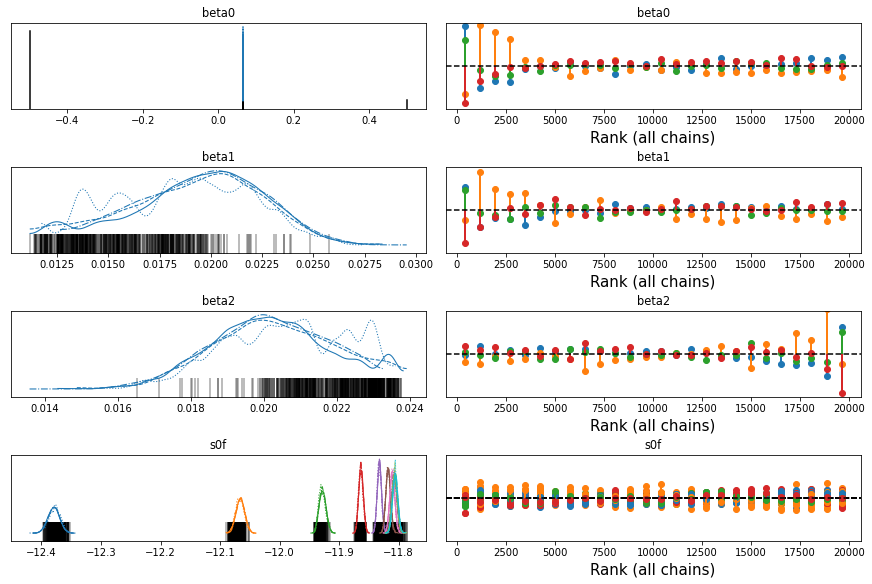

In [9]:
ax = az.plot_trace(az_trace, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, 0.9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k");

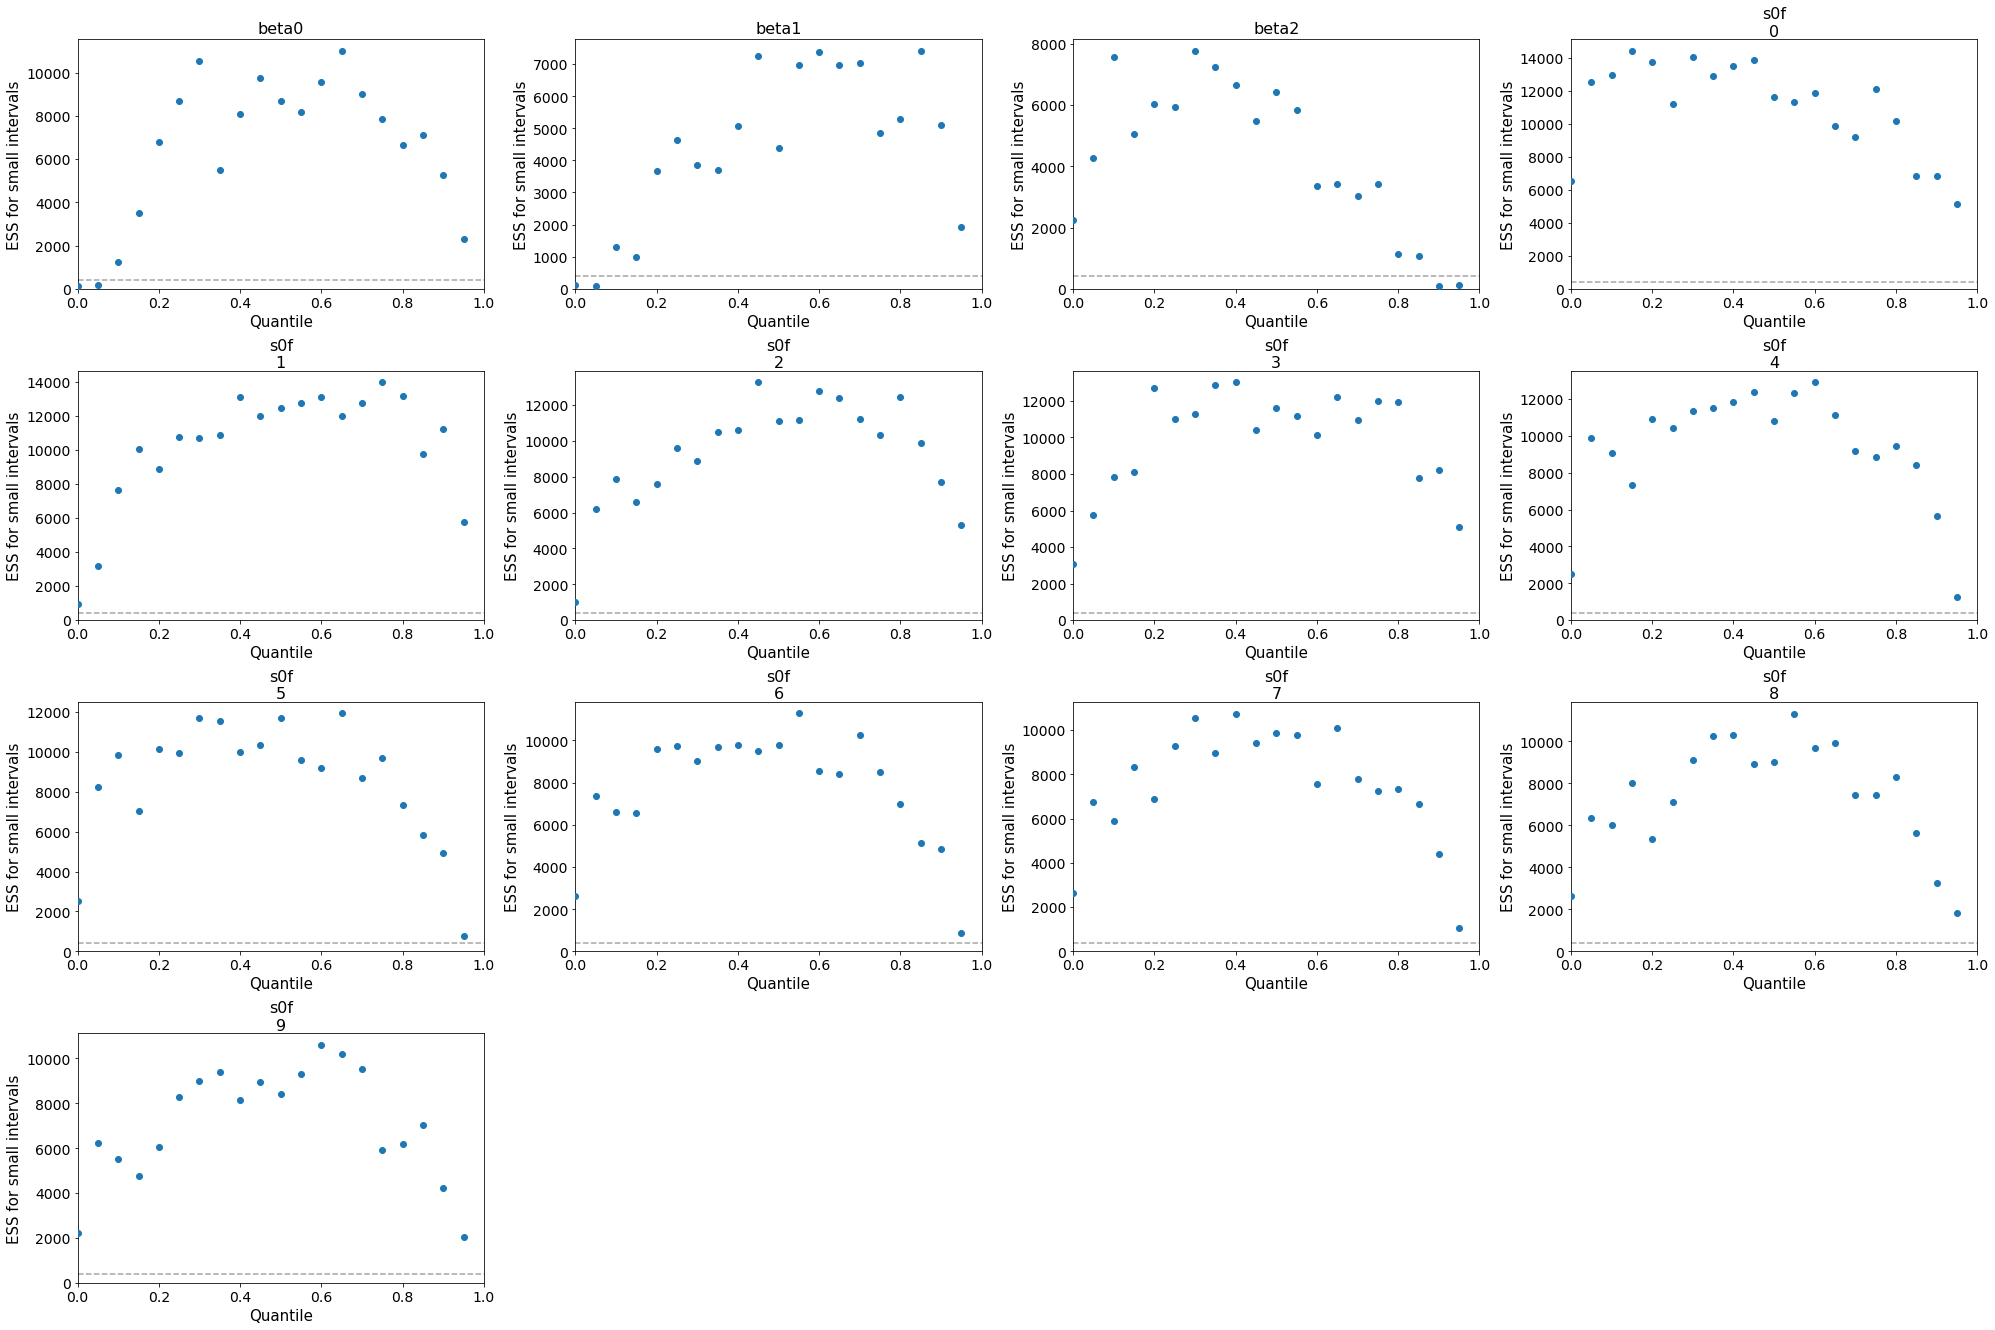

In [10]:
az.plot_ess(az_trace);
i = plt.gcf()

In [11]:
ppc['beta2']

array([0.05825512, 0.09568723, 0.04569055, 0.01009176, 0.00894423,
       0.07542127, 0.080278  , 0.04093771, 0.07594277, 0.01427619,
       0.04988106, 0.07269425, 0.09965   , 0.03283389, 0.00875965,
       0.02886818, 0.09495733, 0.03401922, 0.08015483, 0.00856155,
       0.0660614 , 0.020985  , 0.01812731, 0.0684954 , 0.00678021,
       0.00839572, 0.04417693, 0.0705653 , 0.02732227, 0.09451802,
       0.06368687, 0.06715071, 0.06700986, 0.01024403, 0.01678462,
       0.03945593, 0.00212265, 0.06159724, 0.00648775, 0.08215941,
       0.06137783, 0.07172138, 0.01118721, 0.00371385, 0.04723783,
       0.07498365, 0.08088513, 0.0078074 , 0.06534666, 0.07898827])

<AxesSubplot:xlabel='obs'>

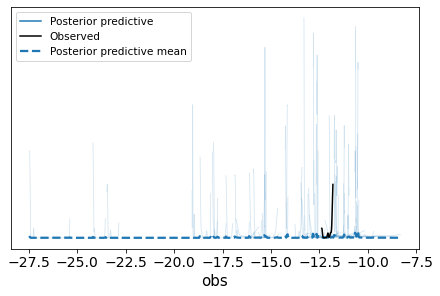

In [12]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model))

In [18]:
print(traza['beta0'].mean())
print(traza['beta1'].mean())
print(traza['beta2'].mean())


#beta0 = 0.066
#beta1 = 0.02
# beta2 = 0.02


0.06596759015201284
0.019093560447103135
0.020346376220709932


(array([  14.,   68.,  592., 2151., 4643., 6139., 4360., 1679.,  337.,
          17.]),
 array([-12.42007919, -12.41244955, -12.40481991, -12.39719027,
        -12.38956063, -12.38193099, -12.37430135, -12.36667171,
        -12.35904207, -12.35141243, -12.34378279]),
 <BarContainer object of 10 artists>)

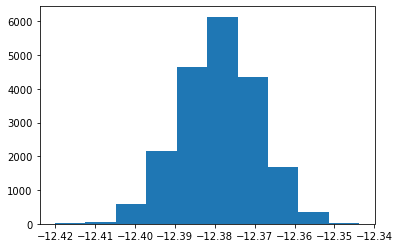

In [32]:
plt.hist(traza['s0f'][:,0])

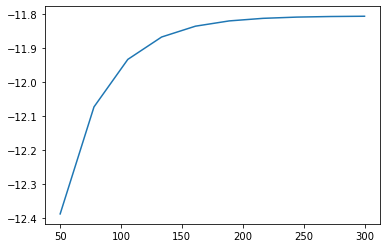

In [19]:
# inferencia

beta0 = traza['beta0'].mean()
beta1 = traza['beta1'].mean()
beta2 = traza['beta2'].mean()

# M = np.linspace(50, 300, 10) #en Tn/Ha
s0HV = s0_hensley(beta0, beta1, beta2, M)
plt.plot(M, s0HV)

In [34]:
p_t = traza['s0f']

In [36]:
p_t.mean(axis = 0).shape

(10,)

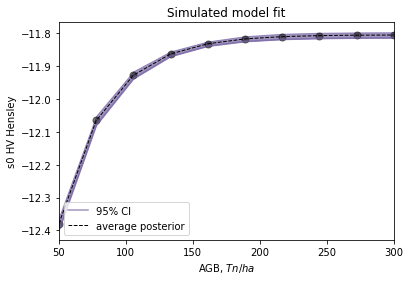

In [40]:
from scipy.stats.mstats import mquantiles

# vectorized bottom and top 2.5% quantiles for "confidence interval"
qs = mquantiles(p_t, [0.025, 0.975], axis=0)
plt.fill_between(M, *qs, alpha=0.7,
                 color="#7A68A6")

plt.plot(M, qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(M, p_t.mean(axis = 0), lw=1, ls="--", color="k",
         label="average posterior")

plt.xlim(M.min(), M.max())
# plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(M, radarObs, color="k", s=50, alpha=0.5)
plt.xlabel("AGB, $Tn/ha$")

plt.ylabel("s0 HV Hensley")
plt.title("Simulated model fit");

In [ ]:
# mu_pp = (ppc["a"] + ppc["b"] * predictor_scaled[:, None]).T

# _, ax = plt.subplots()

# ax.plot(M, radarObs, "o", ms=4, alpha=0.4, label="Data")
# ax.plot(M, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
# az.plot_hpd(
#     predictor_scaled,
#     mu_pp,
#     ax=ax,
#     fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HPD"},
# )
# az.plot_hpd(
#     predictor_scaled,
#     ppc["obs"],
#     ax=ax,
#     fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HPD"},
# )

# ax.set_xlabel("Predictor (stdz)")
# ax.set_ylabel("Outcome (stdz)")
# ax.set_title("Posterior predictive checks")
# ax.legend(ncol=2, fontsize=10);